In [1]:
from pydantic import BaseModel, Field
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [100]:
#df = pd.read_csv('router_v2_validation_data.csv')
df = pd.read_csv('router_v2_test_data.csv')

df["accuracy_gemini_pro"] = 0.87

df.head()

,unique_id,problem_x,is_mcq_x,choices_x,choice_index_correct_x,explanation_correct_x,answer_correct_x,category_x,response_1_x,extracted_answer_1_x,...,extraction_method_counts,math_verify_count,math_verify_accuracy,llm_judge_count,llm_judge_accuracy,regex_fallback_count,regex_fallback_accuracy,reasoning_score,difficulty_score,accuracy_gemini_pro
0,db1a1bdf7aed2b736925eed78bbc2d39,Let $p(x)$ be a polynomial of degree 5 such th...,False,NaN,NaN,Let $q(x) = (x^2 - 1) p(x) - x.$ Then $q(x)$ ...,\frac{3}{56},Intermediate Algebra,Let $q(x) = (x^2 - 1) p(x) - x.$ Then $q(x)$ ...,\frac{1}{9},...,"{'llm_judge': 3.0, 'math_verify': None}",0,0.0,3,0.0,0,0.0,0.510325,0.468612,0.87
1,51a624b053e9c0d44842146880f36e82,Find the greatest integer less than $(\sqrt{7}...,False,NaN,NaN,Let $x = \sqrt{7} + \sqrt{5}$ and $y = \sqrt{7...,13535,Intermediate Algebra,Let $x = \sqrt{7} + \sqrt{5}$ and $y = \sqrt{7...,\boxed{13535},...,"{'llm_judge': 3.0, 'math_verify': None}",0,0.0,3,0.0,0,0.0,0.567715,0.451095,0.87
2,c083dfda89f9b7415ec3aa089729278a,Simplify $\sqrt{242}$.,False,NaN,NaN,Factor 242 as $11^2 \cdot 2$. Then $\sqrt{242}...,11\sqrt2,Prealgebra,We need to simplify $\sqrt{242}$. We can facto...,11\sqrt{2},...,"{'llm_judge': 3.0, 'math_verify': None}",0,0.0,3,1.0,0,0.0,0.565780,0.461718,0.87
3,c631a8db9e4859826c9b8f2648b4229c,"The coordinates of a parallelogram are (5, 3),...",False,NaN,NaN,"Name the points $A(5,3)$, $B(6,8)$, $C(7,4)$, ...",17,Geometry,"Let the vertices of the parallelogram be $A(5,...",\boxed{17},...,"{'llm_judge': None, 'math_verify': 3.0}",3,1.0,0,0.0,0,0.0,0.484099,0.468993,0.87
4,e0c029f2f27705f06977e72bc880f2b9,Find the quotient when $x^6 - 3$ is divided by...,False,NaN,NaN,"We can perform long division. Alternatively, ...",x^5 - x^4 + x^3 - x^2 + x - 1,Intermediate Algebra,Let $P(x) = x^6 - 3$. We want to divide $P(x)$...,x^5 - x^4 + x^3 - x^2 + x - 1,...,"{'llm_judge': 5.0, 'math_verify': None}",0,0.0,5,1.0,0,0.0,0.567715,0.451095,0.87


In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def router_static_analysis(reasoning_threshold: float, difficulty_threshold: float):
    # ─────── Fixed prices per problem ───────
#    price_per_model = {
#        "gemma": 0.04,
#        "qwen": 0.28,
#        "gemini_flash": 0.4,
#        "gemini_pro": 10.0
#    }
    price_per_model = {
        "gemma": 1,
        "qwen": 47.24,
        "gemini_flash": 10.25,
        "gemini_pro": 3201.07
    }
    # ─────── Routing ───────
    reasoning = df["reasoning_score"] >= reasoning_threshold
    difficulty = df["difficulty_score"] >= difficulty_threshold

    use_gemini_pro   = reasoning & difficulty
    use_qwen         = reasoning & ~difficulty
    use_gemini_flash = ~reasoning & difficulty
    use_gemma        = ~reasoning & ~difficulty

    # ─────── Router Performance ───────
    router_accuracy = (
        use_qwen * df["accuracy_qwen"]
        + use_gemma * df["accuracy_gemma"]
        + use_gemini_flash * df["accuracy_gemini"]
        + use_gemini_pro * ((df["accuracy_qwen"] > 0) | (df["accuracy_gemma"] > 0) | (df["accuracy_gemini"] > 0)).astype(int)
    ).mean()

    router_price = (
        use_qwen.sum() * price_per_model["qwen"]
        + use_gemma.sum() * price_per_model["gemma"]
        + use_gemini_flash.sum() * price_per_model["gemini_flash"]
        + use_gemini_pro.sum() * price_per_model["gemini_pro"]
    ) / len(df)

    # ─────── Model Distribution ───────
    model_counts = {
        "Gemini 2.5 Pro": int(use_gemini_pro.sum()),
        "Qwen": int(use_qwen.sum()),
        "Gemini Flash": int(use_gemini_flash.sum()),
        "Gemma": int(use_gemma.sum())
    }

    # ─────── Baseline Model Stats ───────
    baseline = {
        "Gemma": (df["accuracy_gemma"].mean(), price_per_model["gemma"]),
        "Qwen": (df["accuracy_qwen"].mean(), price_per_model["qwen"]),
        "Gemini Flash": (df["accuracy_gemini"].mean(), price_per_model["gemini_flash"]),
        "Gemini Pro": (df["accuracy_gemini_pro"].mean(), price_per_model["gemini_pro"]),
    }

    # ─────── Comparison Table ───────
    comparison_data = {
        "Model": ["Router", "Gemma", "Qwen", "Gemini Flash", "Gemini Pro"],
        "Accuracy": [router_accuracy] + [baseline[m][0] for m in baseline],
        "Avg Price": [router_price] + [baseline[m][1] for m in baseline],
    }

    df_comparison = pd.DataFrame(comparison_data)
    df_comparison["Price Ratio vs Router"] = df_comparison["Avg Price"] / router_price
    df_comparison["Accuracy Diff vs Router"] = df_comparison["Accuracy"] - router_accuracy

    # ─────── Console Output ───────
    print(f"\n📊 Router Thresholds: Reasoning ≥ {reasoning_threshold:.2f}, Difficulty ≥ {difficulty_threshold:.2f}")
    print(f"\n📌 Model Distribution:")
    total = len(df)
    for model, count in model_counts.items():
        print(f"  {model}: {count} ({100 * count / total:.1f}%)")

    print(f"\n📋 Performance Comparison Table:")
    print(df_comparison.round(4).to_string(index=False))

    # ─────── Bar Plots ───────
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    colors = ['red', 'blue', 'green', 'orange', 'purple']

    ax1.bar(df_comparison["Model"], df_comparison["Accuracy"], color=colors, alpha=0.7)
    ax1.set_title("Accuracy Comparison")
    ax1.set_ylabel("Accuracy")
    ax1.set_ylim(0, 1)

    ax2.bar(df_comparison["Model"], df_comparison["Avg Price"], color=colors, alpha=0.7)
    ax2.set_title("Average Price Comparison (log scale)")
    ax2.set_ylabel("Avg Price")
    ax2.set_yscale('log')

    for ax in [ax1, ax2]:
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # ─────── Custom Scatter Plot (Accuracy vs Price) ───────
    sns.set(style="whitegrid")

    # Data for the scatter plot
    df_plot = pd.DataFrame({
        "Results": ["Gemini 2.5 Pro", "Gemini 2.0 Flash", "Qwen 3 14B", "Gemma 3 4B", "Router"],
        "Accuracy": [
            100 * df["accuracy_gemini_pro"].mean(),
            100 * df["accuracy_gemini"].mean(),
            100 * df["accuracy_qwen"].mean(),
            100 * df["accuracy_gemma"].mean(),
            100 * router_accuracy
        ],
        "Price": [
            price_per_model["gemini_pro"],
            price_per_model["gemini_flash"],
            price_per_model["qwen"],
            price_per_model["gemma"],
            router_price
        ]
    })

    thinking_status = {
        "Gemini 2.5 Pro": True,
        "Gemini 2.0 Flash": False,
        "Qwen 3 14B": True,
        "Gemma 3 4B": False,
        "Router": False
    }
    df_plot["Thinking"] = df_plot["Results"].map(thinking_status)

    palette = {True: "#e74c3c", False: "#3498db"}

    # Separate router
    router_df = df_plot[df_plot["Results"] == "Router"]
    others_df = df_plot[df_plot["Results"] != "Router"]

    plt.figure(figsize=(9, 6))
    scatter = sns.scatterplot(
        data=others_df,
        x="Price", y="Accuracy",
        hue="Thinking",
        palette=palette,
        s=300,
        edgecolor="black",
        zorder=3,
        marker='o',
        legend=False
    )

    plt.scatter(router_df["Price"], router_df["Accuracy"],
                color='gold', s=350, edgecolor='black', zorder=4, marker='o')

    for _, row in df_plot.iterrows():
        if row["Results"] == "Gemini 2.0 Flash":
            # Position Gemini 2.0 Flash label above the point to avoid collision with Router
            plt.text(row["Price"], row["Accuracy"] + 1.5, row["Results"], fontsize=10, ha="center", va="bottom")
        else:
            x_offset = row["Price"] * 0.2  # move right (larger than before)
            y_offset = -2.0                 # move downward (adjust as needed)

            plt.text(row["Price"] + x_offset,
                    row["Accuracy"] + y_offset,
                    row["Results"],
                    fontsize=10,
                    ha="left",
                    va="top")
    
    from matplotlib.lines import Line2D

    # Create circular legend markers
    circle_red = Line2D([0], [0], marker='o', color='w', label='Reasoning model',
                        markerfacecolor='#e74c3c', markersize=12, markeredgecolor='black')
    circle_blue = Line2D([0], [0], marker='o', color='w', label='Non-reasoning model',
                        markerfacecolor='#3498db', markersize=12, markeredgecolor='black')
    circle_yellow = Line2D([0], [0], marker='o', color='w', label='Router (hybrid)',
                        markerfacecolor='gold', markersize=12, markeredgecolor='black')

    # Add legend with circle markers
    plt.legend(handles=[circle_red, circle_blue, circle_yellow],
            loc='upper left',
            title='Model Categories',
            frameon=True)

    line_models = ["Gemma 3 4B", "Gemini 2.0 Flash", "Qwen 3 14B", "Gemini 2.5 Pro"]
    line_data = df_plot[df_plot["Results"].isin(line_models)].sort_values("Price")
    plt.plot(line_data["Price"], line_data["Accuracy"], linestyle='--', color="black", linewidth=1)

    plt.xscale("log")
    plt.xlabel("Cost (log scale)")
    plt.ylabel("Model Accuracy (%)")
    plt.ylim(48, 100)
    plt.title("LLM Performances on (MMLU-Pro + MATH-500)")
    plt.grid(True, which="major", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

## Validation Data


📊 Router Thresholds: Reasoning ≥ 0.40, Difficulty ≥ 0.50

📌 Model Distribution:
  Gemini 2.5 Pro: 246 (19.6%)
  Qwen: 963 (76.9%)
  Gemini Flash: 41 (3.3%)
  Gemma: 3 (0.2%)

📋 Performance Comparison Table:
       Model  Accuracy  Avg Price  Price Ratio vs Router  Accuracy Diff vs Router
      Router    0.8268   665.1066                 1.0000                   0.0000
       Gemma    0.5100     1.0000                 0.0015                  -0.3168
        Qwen    0.7828    47.2400                 0.0710                  -0.0441
Gemini Flash    0.8176    10.2500                 0.0154                  -0.0093
  Gemini Pro    0.8700  3201.0700                 4.8129                   0.0432


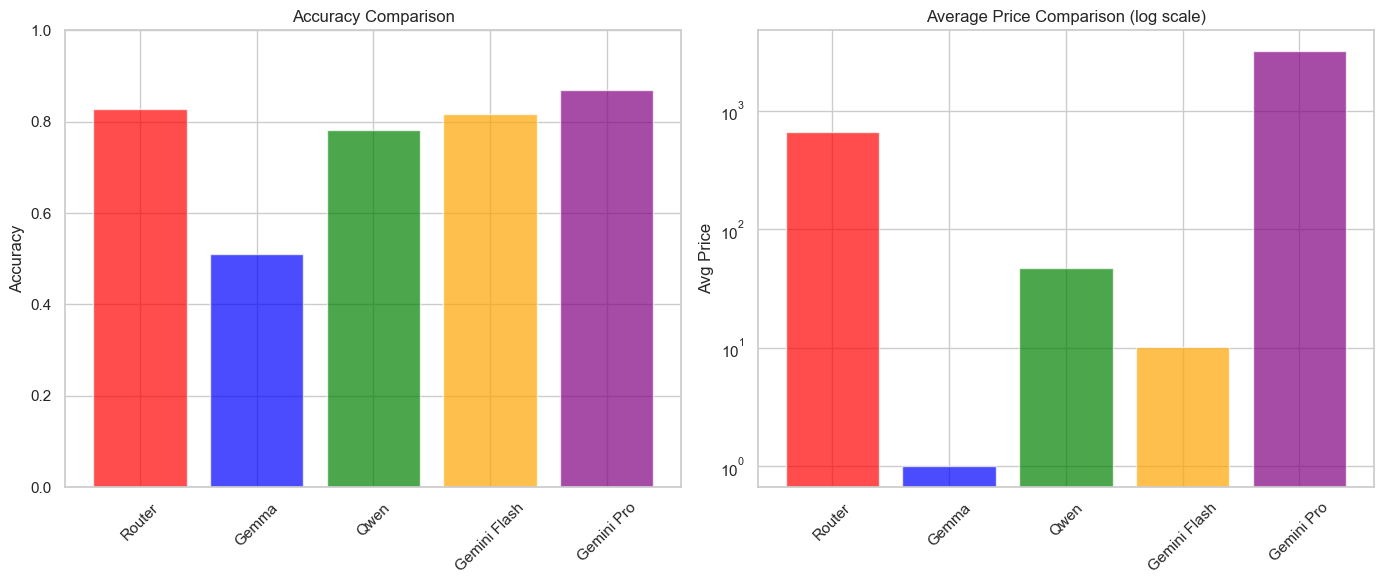

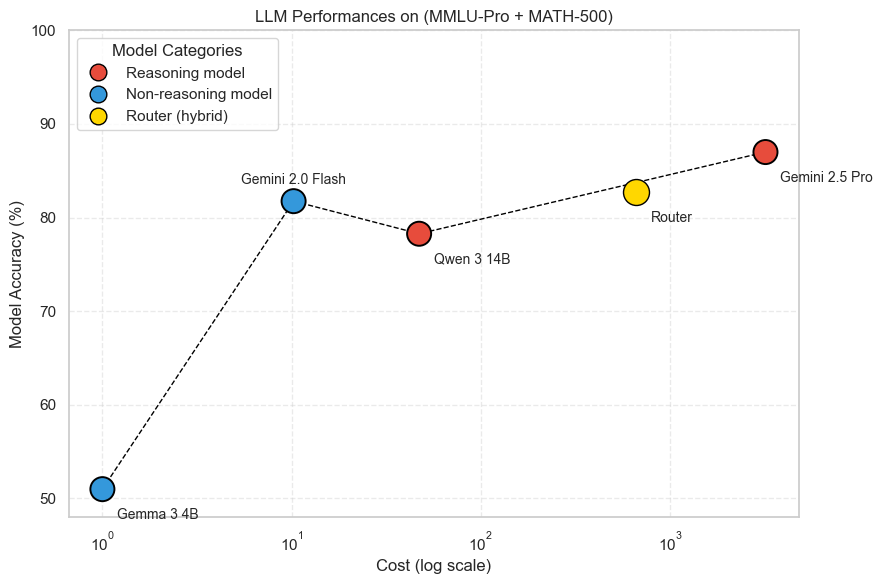

In [99]:
#router_static_analysis(reasoning_threshold=0.3, difficulty_threshold=0.46)
#router_static_analysis(reasoning_threshold=0.256410, difficulty_threshold=0.487179) # 0.256410	0.487179
router_static_analysis(reasoning_threshold=0.4, difficulty_threshold=0.5)

## Test Data


📊 Router Thresholds: Reasoning ≥ 0.40, Difficulty ≥ 0.50

📌 Model Distribution:
  Gemini 2.5 Pro: 261 (20.8%)
  Qwen: 935 (74.6%)
  Gemini Flash: 46 (3.7%)
  Gemma: 11 (0.9%)

📋 Performance Comparison Table:
       Model  Accuracy  Avg Price  Price Ratio vs Router  Accuracy Diff vs Router
      Router    0.8271   702.4191                 1.0000                   0.0000
       Gemma    0.5180     1.0000                 0.0014                  -0.3091
        Qwen    0.7949    47.2400                 0.0673                  -0.0322
Gemini Flash    0.8115    10.2500                 0.0146                  -0.0156
  Gemini Pro    0.8700  3201.0700                 4.5572                   0.0429


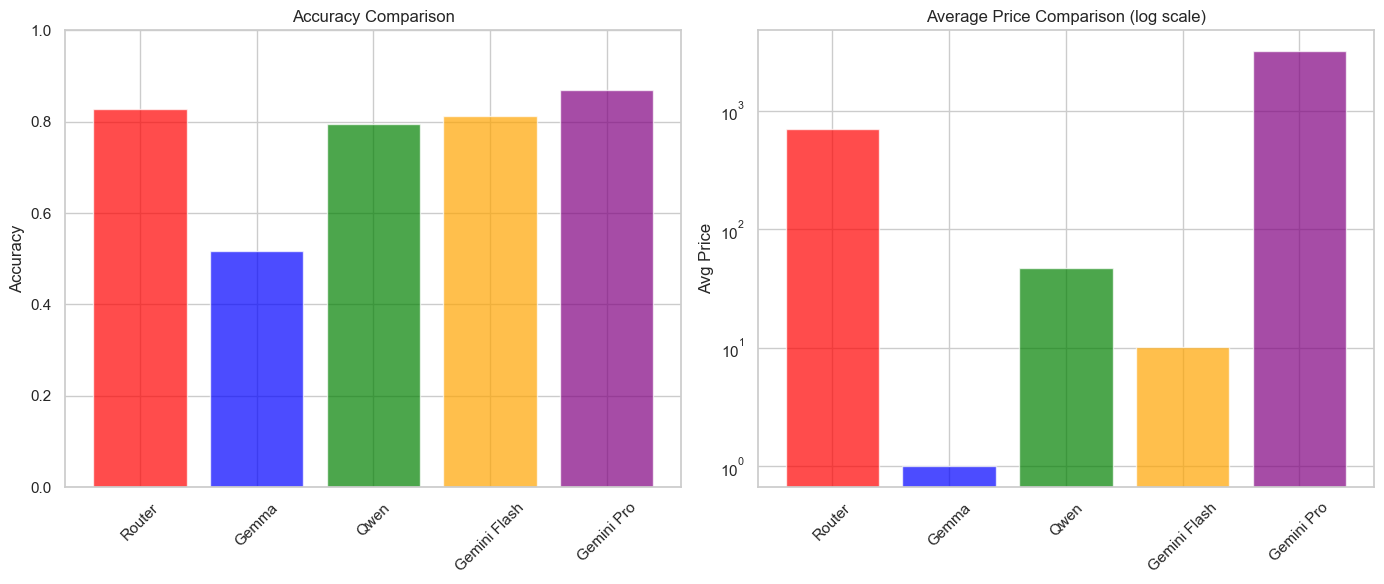

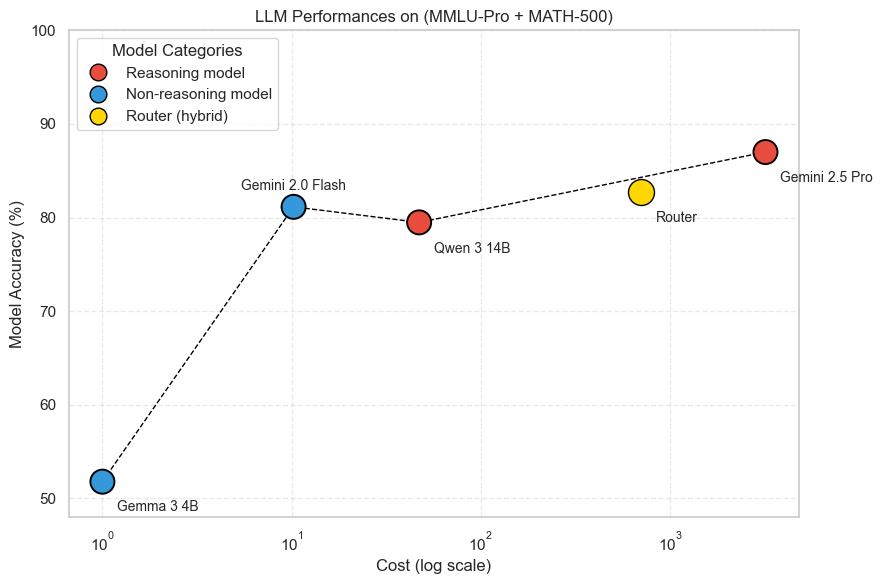

In [102]:
#router_static_analysis(reasoning_threshold=0.3, difficulty_threshold=0.46)
#router_static_analysis(reasoning_threshold=0.256410, difficulty_threshold=0.487179) # 0.256410	0.487179
router_static_analysis(reasoning_threshold=0.4, difficulty_threshold=0.5)

In [15]:
import numpy as np

def find_thresholds_between_best_models():
    accs = {
        "Gemma": df["accuracy_gemma"].mean(),
        "Qwen": df["accuracy_qwen"].mean(),
        "Gemini Flash": df["accuracy_gemini"].mean(),
        "Gemini Pro": df["accuracy_gemini_pro"].mean()
    }

    # Step 1: Sort models by accuracy
    sorted_models = sorted(accs.items(), key=lambda x: x[1], reverse=True)
    best_acc = sorted_models[0][1]
    second_best_acc = sorted_models[1][1]

    print(f"Target range: accuracy between {second_best_acc:.4f} and {best_acc:.4f}")

    reasoning_thresholds = np.linspace(0, 1, 100)
    difficulty_thresholds = np.linspace(0, 1, 100)

    valid_thresholds = []

    for r_th in reasoning_thresholds:
        for d_th in difficulty_thresholds:
            reasoning = df["reasoning_score"] >= r_th
            difficulty = df["difficulty_score"] >= d_th

            use_gemini_pro   = reasoning & difficulty
            use_qwen         = reasoning & ~difficulty
            use_gemini_flash = ~reasoning & difficulty
            use_gemma        = ~reasoning & ~difficulty

            acc = (
                use_qwen * df["accuracy_qwen"]
                + use_gemma * df["accuracy_gemma"]
                + use_gemini_flash * df["accuracy_gemini"]
                + use_gemini_pro * df["accuracy_gemini_pro"]
            ).mean()

            if second_best_acc < acc < best_acc:
                price = (
                    use_qwen.sum() * 0.28 +
                    use_gemma.sum() * 0.04 +
                    use_gemini_flash.sum() * 0.4 +
                    use_gemini_pro.sum() * 10.0
                ) / len(df)

                valid_thresholds.append({
                    "reasoning_threshold": r_th,
                    "difficulty_threshold": d_th,
                    "accuracy": acc,
                    "price": price
                })

    result_df = pd.DataFrame(valid_thresholds)
    result_df = result_df.sort_values("price")  # or accuracy if preferred

    return result_df

In [16]:
optimal_df = find_thresholds_between_best_models()
optimal_df.head()

Target range: accuracy between 0.8176 and 0.8600


,reasoning_threshold,difficulty_threshold,accuracy,price
292,0.525253,0.010101,0.817702,0.499601
290,0.515152,0.010101,0.817702,0.499601
289,0.515152,0.000000,0.817702,0.499601
291,0.525253,0.000000,0.817702,0.499601
288,0.505051,0.010101,0.818148,0.545571


Dataset 1: accuracy between 0.8176 and 0.8600
Dataset 2: accuracy between 0.6667 and 0.8667
Found 1 valid thresholds.


,reasoning_threshold,difficulty_threshold,acc1,price1,acc2,price2,avg_acc,avg_price
0,0.487179,0.0,0.81767,0.622187,0.755556,0.460584,0.786613,0.541385


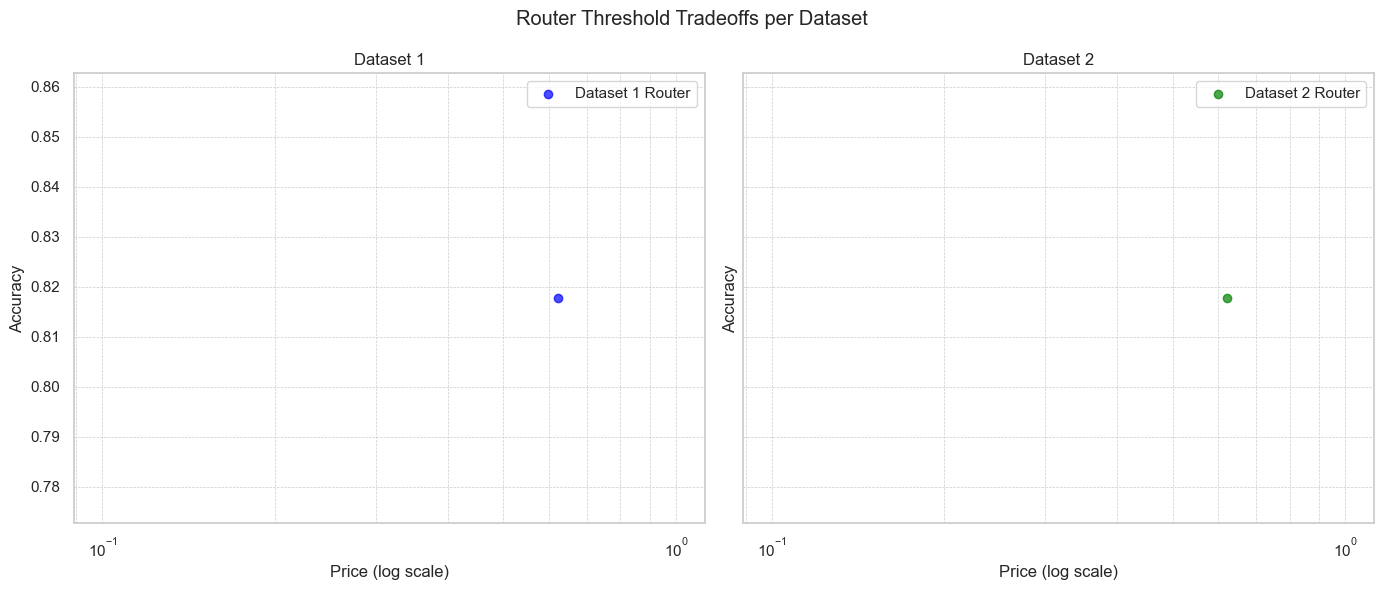

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset

# ─────── Load and prepare dataset 1 ───────
df1 = pd.read_csv('router_v1_validation_data.csv')
df1["accuracy_gemini_pro"] = 0.86
df1["price_qwen"] = 0.28
df1["price_gemma"] = 0.04
df1["price_gemini"] = 0.4
df1["price_gemini_pro"] = 10.0

# ─────── Load and prepare dataset 2 ───────
df2 = pd.read_csv("AIME_2024_Router-v1.csv")

# ─────── Combined Analysis ───────
def find_valid_thresholds_on_both(df1, df2):
    def get_top2_acc(df):
        accs = {
            "Gemma": df["accuracy_gemma"].mean(),
            "Qwen": df["accuracy_qwen"].mean(),
            "Gemini Flash": df["accuracy_gemini"].mean(),
            "Gemini Pro": df["accuracy_gemini_pro"].mean()
        }
        sorted_accs = sorted(accs.items(), key=lambda x: x[1], reverse=True)
        return sorted_accs[1][1], sorted_accs[0][1]

    r_ths = np.linspace(0, 1, 40)
    d_ths = np.linspace(0, 1, 40)

    second1, best1 = get_top2_acc(df1)
    second2, best2 = get_top2_acc(df2)

    print(f"Dataset 1: accuracy between {second1:.4f} and {best1:.4f}")
    print(f"Dataset 2: accuracy between {second2:.4f} and {best2:.4f}")

    results = []

    for r_th in r_ths:
        for d_th in d_ths:
            row = {"reasoning_threshold": r_th, "difficulty_threshold": d_th}

            valid = True
            for i, df in enumerate([df1, df2]):
                reasoning = df.get("reasoning_score", df.get("reasoning")) >= r_th
                difficulty = df.get("difficulty_score", df.get("difficulty")) >= d_th

                use_gemini_pro   = reasoning & difficulty
                use_qwen         = reasoning & ~difficulty
                use_gemini_flash = ~reasoning & difficulty
                use_gemma        = ~reasoning & ~difficulty

                acc = (
                    use_qwen * df["accuracy_qwen"]
                    + use_gemma * df["accuracy_gemma"]
                    + use_gemini_flash * df["accuracy_gemini"]
                    + use_gemini_pro * df["accuracy_gemini_pro"]
                ).mean()

                price = (
                    use_qwen * df["price_qwen"]
                    + use_gemma * df["price_gemma"]
                    + use_gemini_flash * df["price_gemini"]
                    + use_gemini_pro * df["price_gemini_pro"]
                ).mean()

                row[f"acc{i+1}"] = acc
                row[f"price{i+1}"] = price

                # Ensure both datasets independently satisfy the accuracy range
                low, high = (second1, best1) if i == 0 else (second2, best2)
                if not (low < acc < high):
                    valid = False

            if valid:
                row["avg_acc"] = (row["acc1"] + row["acc2"]) / 2
                row["avg_price"] = (row["price1"] + row["price2"]) / 2
                results.append(row)

    return pd.DataFrame(results).sort_values("avg_price")

# Run the search
optimal_df = find_valid_thresholds_on_both(df1, df2)
print(f"Found {len(optimal_df)} valid thresholds.")
display(optimal_df.head(20))

# ─────── Visualization ───────
def plot_dual_accuracy_price(df, df_name, ax, color):
    ax.scatter(df["price1"], df["acc1"], label=f"{df_name} Router", alpha=0.7, marker='o', color=color)
    ax.set_title(f"{df_name}")
    ax.set_xlabel("Price (log scale)")
    ax.set_ylabel("Accuracy")
    ax.set_xscale("log")
    ax.grid(True, which="major", linestyle="--", linewidth=0.5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
plot_dual_accuracy_price(optimal_df, "Dataset 1", ax1, "blue")
plot_dual_accuracy_price(optimal_df, "Dataset 2", ax2, "green")

ax1.legend()
ax2.legend()
plt.suptitle("Router Threshold Tradeoffs per Dataset")
plt.tight_layout()
plt.show()

In [100]:
def find_valid_thresholds_on_both(df1, df2, target_ratio=0.90):
    r_ths = np.linspace(0, 1, 40)
    d_ths = np.linspace(0, 1, 40)

    # Calculate target accuracies based on Gemini Pro
    target_acc1 = df1["accuracy_gemini_pro"].mean() * target_ratio
    target_acc2 = df2["accuracy_gemini_pro"].mean() * target_ratio

    print(f"Target accuracy (Dataset 1): {target_acc1:.4f}")
    print(f"Target accuracy (Dataset 2): {target_acc2:.4f}")

    results = []

    for r_th in r_ths:
        for d_th in d_ths:
            row = {"reasoning_threshold": r_th, "difficulty_threshold": d_th}
            valid = True

            for i, df, target in zip([1, 2], [df1, df2], [target_acc1, target_acc2]):
                reasoning = df.get("reasoning_score", df.get("reasoning")) >= r_th
                difficulty = df.get("difficulty_score", df.get("difficulty")) >= d_th

                use_gemini_pro   = reasoning & difficulty
                use_qwen         = reasoning & ~difficulty
                use_gemini_flash = ~reasoning & difficulty
                use_gemma        = ~reasoning & ~difficulty

                acc = (
                    use_qwen * df["accuracy_qwen"]
                    + use_gemma * df["accuracy_gemma"]
                    + use_gemini_flash * df["accuracy_gemini"]
                    + use_gemini_pro * df["accuracy_gemini_pro"]
                ).mean()

                price = (
                    use_qwen * df["price_qwen"]
                    + use_gemma * df["price_gemma"]
                    + use_gemini_flash * df["price_gemini"]
                    + use_gemini_pro * df["price_gemini_pro"]
                ).mean()

                row[f"acc{i}"] = acc
                row[f"price{i}"] = price

                if acc < target:
                    valid = False

            if valid:
                row["avg_acc"] = (row["acc1"] + row["acc2"]) / 2
                row["avg_price"] = (row["price1"] + row["price2"]) / 2
                results.append(row)

    return pd.DataFrame(results).sort_values("avg_price")

In [101]:
optimal_df = find_valid_thresholds_on_both(df1, df2, target_ratio=0.85)
print(f"Found {len(optimal_df)} valid thresholds.")
display(optimal_df.head(10))

Target accuracy (Dataset 1): 0.7310
Target accuracy (Dataset 2): 0.7367
Found 357 valid thresholds.


,reasoning_threshold,difficulty_threshold,acc1,price1,acc2,price2,reasoning_threshold_original,difficulty_threshold_original,avg_acc,avg_price
356,0.615385,0.282051,0.731945,0.909306,0.755556,0.452757,0.450382,0.360753,0.743750,0.681031
355,0.615385,0.256410,0.746406,0.940910,0.755556,0.452757,0.450382,0.352053,0.750981,0.696833
354,0.615385,0.230769,0.755185,0.949529,0.755556,0.452757,0.450382,0.343352,0.755370,0.701143
353,0.615385,0.205128,0.755387,0.969928,0.755556,0.452757,0.450382,0.334651,0.755471,0.711342
352,0.615385,0.179487,0.759218,0.977686,0.755556,0.452757,0.450382,0.325951,0.757387,0.715221
351,0.615385,0.153846,0.768635,0.994637,0.755556,0.452757,0.450382,0.317250,0.762095,0.723697
350,0.615385,0.128205,0.776297,1.002394,0.755556,0.452757,0.450382,0.308549,0.765926,0.727576
349,0.615385,0.102564,0.796143,1.023943,0.755556,0.452757,0.450382,0.299849,0.775849,0.738350
348,0.615385,0.076923,0.816148,1.050375,0.755556,0.452757,0.450382,0.291148,0.785852,0.751566
347,0.615385,0.051282,0.816680,1.050662,0.755556,0.452757,0.450382,0.282447,0.786118,0.751710


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def router_static_analysis_2d(df, reasoning_threshold: float, difficulty_threshold: float):
    # ─────── Routing ───────
    reasoning = df["reasoning"] >= reasoning_threshold
    difficulty = df["difficulty"] >= difficulty_threshold

    use_gemini_pro   = reasoning & difficulty
    use_qwen         = reasoning & ~difficulty
    use_gemini_flash = ~reasoning & difficulty
    use_gemma        = ~reasoning & ~difficulty

    # ─────── Router Performance ───────
    router_accuracy = (
        use_qwen * df["accuracy_qwen"]
        + use_gemma * df["accuracy_gemma"]
        + use_gemini_flash * df["accuracy_gemini"]
        + use_gemini_pro * df["accuracy_gemini_pro"]
    ).mean()

    router_price = (
        (use_qwen * df["price_qwen"])
        + (use_gemma * df["price_gemma"])
        + (use_gemini_flash * df["price_gemini"])
        + (use_gemini_pro * df["price_gemini_pro"])
    ).mean()

    # ─────── RouteLLM Router Price & Accuracy ───────
    if "picked" in df.columns:
        routellm_price = (
            (df["picked"] == "strong") * df["price_gemini_pro"]
            + (df["picked"] == "weak") * df["price_gemini"]
        ).mean()
        routellm_accuracy = (
            (df["picked"] == "strong") * df["accuracy_gemini_pro"]
            + (df["picked"] == "weak") * df["accuracy_gemini"]
        ).mean()
    else:
        routellm_price = None
        routellm_accuracy = None

    # ─────── Model Distribution ───────
    model_counts = {
        "Gemini 2.5 Pro": int(use_gemini_pro.sum()),
        "Qwen": int(use_qwen.sum()),
        "Gemini Flash": int(use_gemini_flash.sum()),
        "Gemma": int(use_gemma.sum())
    }

    # ─────── Baseline Model Stats ───────
    baseline = {
        "Gemma": (df["accuracy_gemma"].mean(), df["price_gemma"].mean()),
        "Qwen": (df["accuracy_qwen"].mean(), df["price_qwen"].mean()),
        "Gemini Flash": (df["accuracy_gemini"].mean(), df["price_gemini"].mean()),
        "Gemini Pro": (df["accuracy_gemini_pro"].mean(), df["price_gemini_pro"].mean()),
    }

    # ─────── Comparison Table ───────
    comparison_data = {
        "Model": ["Router", "RouteLLM", "Gemma", "Qwen", "Gemini Flash", "Gemini Pro"],
        "Accuracy": [router_accuracy, routellm_accuracy] + [baseline[m][0] for m in baseline],
        "Avg Price": [router_price, routellm_price] + [baseline[m][1] for m in baseline],
    }

    df_comparison = pd.DataFrame(comparison_data)
    df_comparison["Price Ratio vs Router"] = df_comparison["Avg Price"] / router_price
    df_comparison["Accuracy Diff vs Router"] = df_comparison["Accuracy"] - router_accuracy

    # ─────── Console Output ───────
    print(f"\n📊 Router Thresholds: Reasoning ≥ {reasoning_threshold:.2f}, Difficulty ≥ {difficulty_threshold:.2f}")
    print(f"\n📌 Model Distribution:")
    total = len(df)
    for model, count in model_counts.items():
        print(f"  {model}: {count} ({100 * count / total:.1f}%)")

    print(f"\n📋 Performance Comparison Table:")
    print(df_comparison.round(4).to_string(index=False))

    # ─────── Bar Plots (excluding RouteLLM) ───────
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'gray']
    plot_df = df_comparison[df_comparison["Model"] != "RouteLLM"]

    ax1.bar(plot_df["Model"], plot_df["Accuracy"], color=colors, alpha=0.7)
    ax1.set_title("Accuracy Comparison")
    ax1.set_ylabel("Accuracy")
    ax1.set_ylim(0, 1)

    ax2.bar(plot_df["Model"], plot_df["Avg Price"], color=colors, alpha=0.7)
    ax2.set_title("Average Price Comparison (log scale)")
    ax2.set_ylabel("Avg Price")
    ax2.set_yscale('log')

    for ax in [ax1, ax2]:
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # ─────── Custom Scatter Plot (excluding RouteLLM) ───────
    sns.set(style="whitegrid")

    df_plot = pd.DataFrame({
        "Results": ["Gemini 2.5 Pro", "Gemini 2.0 Flash", "Qwen 3 14B", "Gemma 3 4B", "Router"],
        "Accuracy": [
            100 * df["accuracy_gemini_pro"].mean(),
            100 * df["accuracy_gemini"].mean(),
            100 * df["accuracy_qwen"].mean(),
            100 * df["accuracy_gemma"].mean(),
            100 * router_accuracy
        ],
        "Price": [
            df["price_gemini_pro"].mean(),
            df["price_gemini"].mean(),
            df["price_qwen"].mean(),
            df["price_gemma"].mean(),
            router_price
        ]
    })

    thinking_status = {
        "Gemini 2.5 Pro": True,
        "Gemini 2.0 Flash": False,
        "Qwen 3 14B": True,
        "Gemma 3 4B": False,
        "Router": False
    }
    df_plot["Thinking"] = df_plot["Results"].map(thinking_status)

    palette = {True: "#e74c3c", False: "#3498db"}

    # Separate router
    router_df = df_plot[df_plot["Results"] == "Router"]
    others_df = df_plot[df_plot["Results"] != "Router"]

    plt.figure(figsize=(9, 6))
    sns.scatterplot(
        data=others_df,
        x="Price", y="Accuracy",
        hue="Thinking",
        palette=palette,
        s=300,
        edgecolor="black",
        zorder=3,
        marker='o',
        legend=False
    )

    plt.scatter(router_df["Price"], router_df["Accuracy"],
                color='gold', s=350, edgecolor='black', zorder=4, marker='o')

    for _, row in df_plot.iterrows():
        x_offset = row["Price"] * 0.2
        y_offset = -2.0
        plt.text(row["Price"] + x_offset,
                row["Accuracy"] + y_offset,
                row["Results"],
                fontsize=10,
                ha="left",
                va="top")

    from matplotlib.lines import Line2D
    circle_red = Line2D([0], [0], marker='o', color='w', label='Reasoning model',
                        markerfacecolor='#e74c3c', markersize=12, markeredgecolor='black')
    circle_blue = Line2D([0], [0], marker='o', color='w', label='Non-reasoning model',
                        markerfacecolor='#3498db', markersize=12, markeredgecolor='black')
    circle_yellow = Line2D([0], [0], marker='o', color='w', label='Router (hybrid)',
                        markerfacecolor='gold', markersize=12, markeredgecolor='black')

    plt.legend(handles=[circle_red, circle_blue, circle_yellow],
            loc='upper left',
            title='Model Categories',
            frameon=True)

    line_models = ["Gemma 3 4B", "Gemini 2.0 Flash", "Qwen 3 14B", "Gemini 2.5 Pro"]
    line_data = df_plot[df_plot["Results"].isin(line_models)].sort_values("Price")
    plt.plot(line_data["Price"], line_data["Accuracy"], linestyle='--', color="black", linewidth=1)

    plt.xscale("log")
    plt.xlabel("Cost (log scale)")
    plt.ylabel("Model Accuracy (%)")
    plt.ylim(0, 100)
    plt.title("Model Performances on AIME 2024")
    plt.grid(True, which="major", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

In [1]:
import pandas as pd
from datasets import load_dataset

# ─────── Load datasets and convert to DataFrame ───────
gemma_ds = load_dataset("HPC-Boys/AIME-2024-Gemma-3-4b")["train"].to_pandas()
qwen_ds = load_dataset("HPC-Boys/AIME-2024-Qwen-3-14B")["train"].to_pandas()
flash_ds = load_dataset("HPC-Boys/flash-AIME2024")["train"].to_pandas()
pro_ds = load_dataset("HPC-Boys/AIME-2024-Gemini-2.5-Pro")["train"].to_pandas()

# ─────── Standardize column names ───────
for dataset in [gemma_ds, qwen_ds, flash_ds, pro_ds]:
    dataset.rename(columns={
        "Question ID": "id",
        "Correct Count": "correct_count",
        "Token Count": "token_count",
        "Price / Mil": "price_per_million"
    }, inplace=True)

# ─────── Rename for merge and clarity ───────
gemma_ds.rename(columns={"token_count": "gemma_tokens", "price_per_million": "price_gemma"}, inplace=True)
qwen_ds.rename(columns={"token_count": "qwen_tokens", "price_per_million": "price_qwen"}, inplace=True)
flash_ds.rename(columns={"token_count": "flash_tokens", "price_per_million": "flash_price"}, inplace=True)
pro_ds.rename(columns={"token_count": "pro_tokens", "price_per_million": "pro_price"}, inplace=True)

# ─────── Merge on question ID ───────
merged_df = gemma_ds[["id", "gemma_tokens", "price_gemma"]].merge(
    qwen_ds[["id", "qwen_tokens", "price_qwen"]], on="id"
).merge(
    flash_ds[["id", "flash_tokens", "flash_price"]], on="id"
).merge(
    pro_ds[["id", "pro_tokens", "pro_price"]], on="id"
)

# ─────── Compute actual prices per query ───────
merged_df["price_qwen"] = merged_df["price_qwen"] * (merged_df["qwen_tokens"] / 3) / 1000
merged_df["price_gemini"] = merged_df["flash_price"] * (merged_df["flash_tokens"] / 3) / 1000
merged_df["price_gemma"] = merged_df["price_gemma"] * (merged_df["gemma_tokens"] / 3) / 1000
merged_df["price_gemini_pro"] = merged_df["pro_price"] * (merged_df["pro_tokens"] / 3) / 1000

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

# ─────── Load router metadata ───────
df = pd.read_csv("AIME_2024_Router-v2_with_routing.csv")


📊 Router Thresholds: Reasoning ≥ 0.40, Difficulty ≥ 0.50

📌 Model Distribution:
  Gemini 2.5 Pro: 3 (10.0%)
  Qwen: 27 (90.0%)
  Gemini Flash: 0 (0.0%)
  Gemma: 0 (0.0%)

📋 Performance Comparison Table:
       Model  Accuracy  Avg Price  Price Ratio vs Router  Accuracy Diff vs Router
      Router    0.6778    21.0509                 1.0000                   0.0000
    RouteLLM    0.4556    42.1463                 2.0021                  -0.2222
       Gemma    0.0667     0.0748                 0.0036                  -0.6111
        Qwen    0.6667     3.2307                 0.1535                  -0.0111
Gemini Flash    0.3333     0.6914                 0.0328                  -0.3444
  Gemini Pro    0.8667   215.9258                10.2573                   0.1889


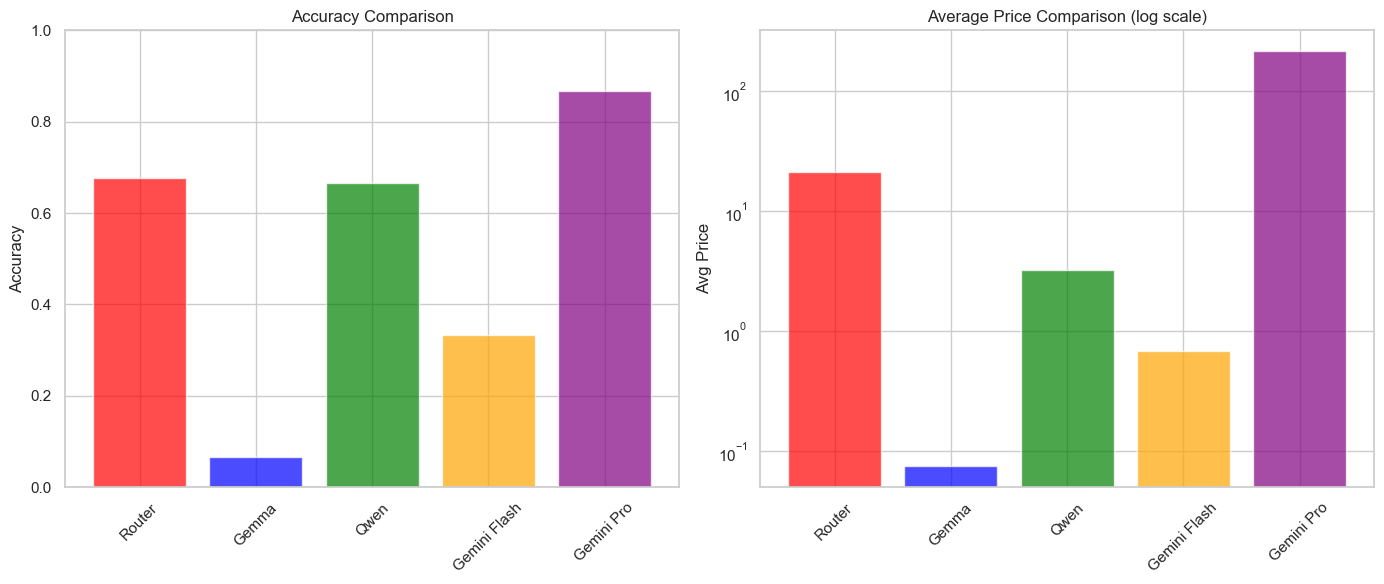

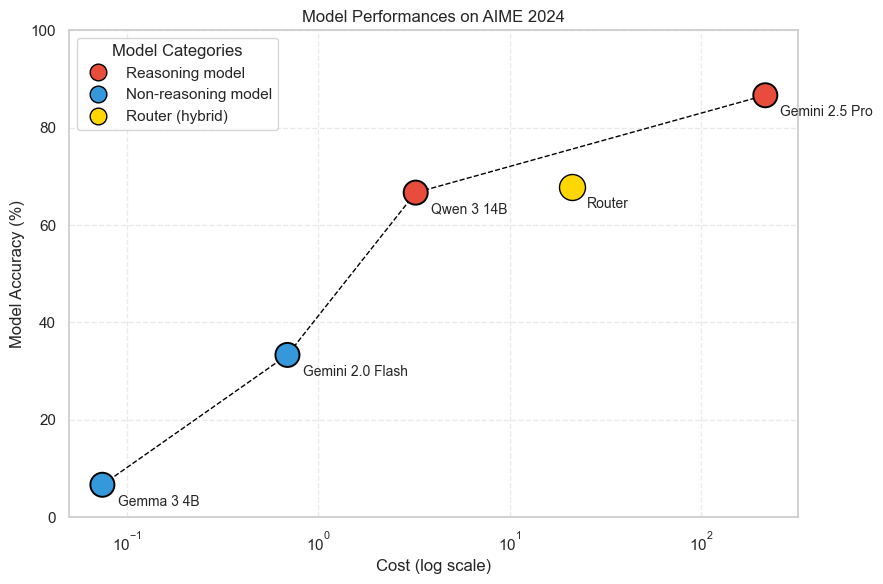

In [10]:
#router_static_analysis_2d(df, reasoning_threshold=0.30, difficulty_threshold=0.46)
#router_static_analysis_2d(df, reasoning_threshold=0.256410, difficulty_threshold=0.487179) # 0.256410	0.487179
router_static_analysis_2d(df, reasoning_threshold=0.4, difficulty_threshold=0.5)

In [212]:
import numpy as np

def find_thresholds_above_model_line(df, step=0.05):
    # Get base model accuracy and price
    models = ["Gemma", "Gemini Flash", "Qwen", "Gemini Pro"]
    model_points = [
        (df["price_gemma"].mean(), df["accuracy_gemma"].mean()),
        (df["price_gemini"].mean(), df["accuracy_gemini"].mean()),
        (df["price_qwen"].mean(), df["accuracy_qwen"].mean()),
        (df["price_gemini_pro"].mean(), df["accuracy_gemini_pro"].mean())
    ]

    def is_above_all_segments(p, model_points, eps=1e-5):
        x, y = p

        # Reject if too close to any model point
        for mx, my in model_points:
            if min(x - mx, y - my) < eps:
                return False

        # Check if above all line segments
        for (x1, y1), (x2, y2) in zip(model_points, model_points[1:]):
            if x < min(x1, x2) or x > max(x1, x2):
                continue  # Outside segment range

            log_x1, log_x2 = np.log(x1), np.log(x2)
            log_x = np.log(x)
            slope = (y2 - y1) / (log_x2 - log_x1)
            y_on_line = y1 + slope * (log_x - log_x1)

            if y < y_on_line:  # must be strictly above
                return False

        return True
    
    solutions = []

    # Search thresholds
    for reasoning_th in np.arange(0, 1.01, step):
        for difficulty_th in np.arange(0, 1.01, step):
            reasoning = df["reasoning"] >= reasoning_th
            difficulty = df["difficulty"] >= difficulty_th

            use_gemini_pro   = reasoning & difficulty
            use_qwen         = reasoning & ~difficulty
            use_gemini_flash = ~reasoning & difficulty
            use_gemma        = ~reasoning & ~difficulty

            router_acc = (
                use_qwen * df["accuracy_qwen"]
                + use_gemma * df["accuracy_gemma"]
                + use_gemini_flash * df["accuracy_gemini"]
                + use_gemini_pro * df["accuracy_gemini_pro"]
            ).mean()

            router_price = (
                (use_qwen * df["price_qwen"])
                + (use_gemma * df["price_gemma"])
                + (use_gemini_flash * df["price_gemini"])
                + (use_gemini_pro * df["price_gemini_pro"])
            ).mean()

            if is_above_all_segments((router_price, router_acc), model_points):
                solutions.append({
                    "reasoning_threshold": reasoning_th,
                    "difficulty_threshold": difficulty_th,
                    "router_accuracy": router_acc,
                    "router_price": router_price
                })

    return solutions

In [213]:
result = find_thresholds_above_model_line(df)

# Sort by accuracy / price ratio
result.sort(key=lambda x: x["router_accuracy"] / x["router_price"], reverse=True)

# Print top 3 results
for i, solution in enumerate(result):
    print(f"Top {i+1}:")
    print(f"  Reasoning Threshold: {solution['reasoning_threshold']}")
    print(f"  Difficulty Threshold: {solution['difficulty_threshold']}")
    print(f"  Accuracy: {solution['router_accuracy']}")
    print(f"  Price: {solution['router_price']}")
    print(f"  Accuracy/Price Ratio: {solution['router_accuracy'] / solution['router_price']}")
    router_static_analysis_2d(df, solution['reasoning_threshold'], solution['difficulty_threshold'])
    print("\n")

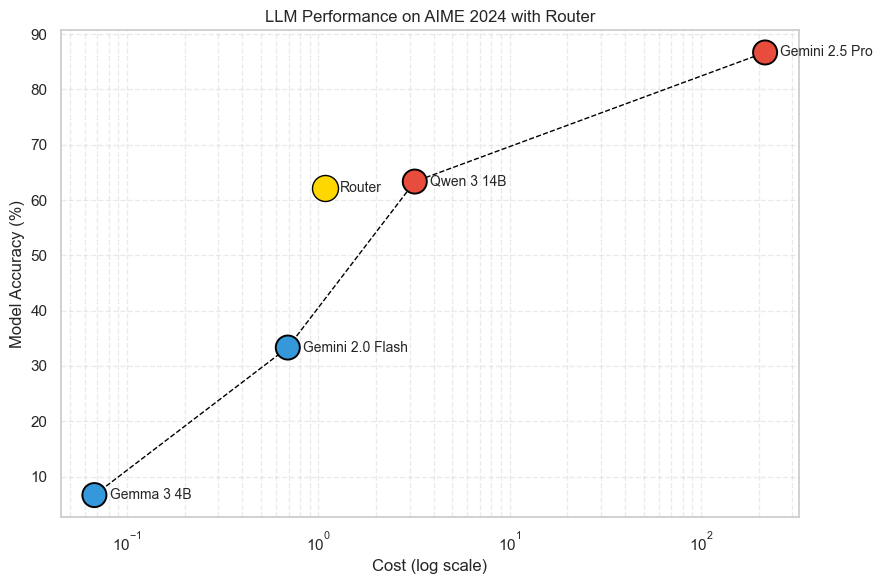

In [2]:


# Step 1: Create the table data
data = {
    "Results": ["Gemini 2.5 Pro", "Gemini 2.0 Flash", "Qwen 3 14B", "Gemma 3 4B", "Router"],
    "Accuracy": [86.66666667, 33.33333333, 63.33333333, 6.666666667,62.22222],
    "Token Count": [21592.57778, 1728.622222, 11380.88889, 1686.355556,33255.23333],
    "Price": [215.9257778, 0.6914488889, 3.186648889, 0.06745422222,1.08349492]
}

df = pd.DataFrame(data)

# Step 2: Define which models are "thinking" models
thinking_status = {
    "Gemini 2.5 Pro": True,
    "Gemini 2.0 Flash": False,
    "Qwen 3 14B": True,
    "Gemma 3 4B": False,
    "Router": False
}
df["Thinking"] = df["Results"].map(thinking_status)

# Step 3: Define color palette for thinking/non-thinking
palette = {
    True: "#e74c3c",   # Red for thinking
    False: "#3498db"   # Blue for non-thinking
}

# Step 4: Plotting
plt.figure(figsize=(9, 6))
sns.set(style="whitegrid")

# Separate router for custom styling
router_df = df[df["Results"] == "Router"]
others_df = df[df["Results"] != "Router"]

# Plot thinking/non-thinking models as circles without legend
scatter = sns.scatterplot(
    data=others_df,
    x="Price", y="Accuracy",
    hue="Thinking",
    palette=palette,
    s=300,
    edgecolor="black",
    zorder=3,
    marker='o',
    legend=False
)

# Plot Router in gold
plt.scatter(router_df["Price"], router_df["Accuracy"],
            color='gold', s=350, edgecolor='black', zorder=4, marker='o')

# Add labels (slightly offset to the right)
for _, row in df.iterrows():
    plt.text(row["Price"] * 1.2, row["Accuracy"], row["Results"], fontsize=10, va="center")

# Draw performance trend line: Flash → Qwen → Gemini Pro
line_models = ["Gemma 3 4B", "Gemini 2.0 Flash", "Qwen 3 14B", "Gemini 2.5 Pro"]
line_data = df[df["Results"].isin(line_models)].sort_values("Price")
plt.plot(line_data["Price"], line_data["Accuracy"], linestyle='--', color="black", linewidth=1)

# Axes and styling
plt.xscale("log")
plt.xlabel("Cost (log scale)")
plt.ylabel("Model Accuracy (%)")
plt.title("LLM Performance on AIME 2024 with Router")
plt.grid(True, which="major", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [7]:
from RouteLLM.route_llm_classifier import RouteLLMClassifier
import pandas as pd
import os

# Initialize router with BERT to avoid API dependencies for routing decisions
router = RouteLLMClassifier(
    strong_model='google/gemini-2.5-pro-preview', 
    weak_model='google/gemini-2.0-flash-001',
    api_base="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    threshold=0.8,  # Adjust threshold as needed
    router_type="bert"  # Use BERT router (works offline)
)

df = pd.read_csv('AIME_2024_Router-v2.csv')

# Add routing decisions to 'picked' column
for i, row in df.iterrows():
    routing_decision = router.predict_class(row['problem'])
    confidence_score = router.get_confidence_score(row['problem'])
    
    print(f"Problem {i+1}: {routing_decision} (confidence: {confidence_score:.4f})")
    
    # Save routing decision to 'picked' column
    df.at[i, 'picked'] = routing_decision
    
    # Optional: also save confidence score
    df.at[i, 'confidence'] = confidence_score

# Save updated dataframe
df.to_csv('AIME_2024_Router-v2_with_routing.csv', index=False)
print(f"\nProcessed {len(df)} problems")
print(f"Strong model selected: {(df['picked'] == 'strong').sum()} times")
print(f"Weak model selected: {(df['picked'] == 'weak').sum()} times")

Problem 1: weak (confidence: 0.6262)
Problem 2: weak (confidence: 0.7122)
Problem 3: weak (confidence: 0.6461)
Problem 4: weak (confidence: 0.6511)
Problem 5: weak (confidence: 0.7416)
Problem 6: strong (confidence: 0.8286)
Problem 7: weak (confidence: 0.7666)
Problem 8: weak (confidence: 0.6264)
Problem 9: weak (confidence: 0.7734)
Problem 10: weak (confidence: 0.7757)
Problem 11: strong (confidence: 0.8817)
Problem 12: weak (confidence: 0.7540)
Problem 13: weak (confidence: 0.5601)
Problem 14: weak (confidence: 0.7980)
Problem 15: weak (confidence: 0.7057)
Problem 16: weak (confidence: 0.6173)
Problem 17: weak (confidence: 0.5415)
Problem 18: weak (confidence: 0.7142)
Problem 19: weak (confidence: 0.6401)
Problem 20: weak (confidence: 0.5604)
Problem 21: strong (confidence: 0.8199)
Problem 22: weak (confidence: 0.7612)
Problem 23: weak (confidence: 0.7583)
Problem 24: strong (confidence: 0.8731)
Problem 25: weak (confidence: 0.5881)
Problem 26: weak (confidence: 0.7138)
Problem 27: s

In [3]:
from RouteLLM.route_llm_classifier import RouteLLMClassifier
import pandas as pd
import os

# Initialize router with BERT to avoid API dependencies for routing decisions
router = RouteLLMClassifier(
    strong_model='google/gemini-2.5-pro-preview', 
    weak_model='google/gemma-3-4b-it',
    threshold=0.5,  # Adjust threshold as needed
    router_type="bert"  # Use BERT router (works offline)
)

df = pd.read_csv('router_v2_test_data.csv')

# Add routing decisions to 'picked' column
for i, row in df.iterrows():
    routing_decision = router.predict_class(row['problem_x'])
    confidence_score = router.get_confidence_score(row['problem_x'])
    
    print(f"Problem {i+1}: {routing_decision} (confidence: {confidence_score:.4f})")
    
    # Save routing decision to 'picked' column
    df.at[i, 'picked'] = routing_decision
    
    # Optional: also save confidence score
    df.at[i, 'confidence'] = confidence_score

# Save updated dataframe
df.to_csv('router_v2_test_data_with_routing.csv', index=False)
print(f"\nProcessed {len(df)} problems")
print(f"Strong model selected: {(df['picked'] == 'strong').sum()} times")
print(f"Weak model selected: {(df['picked'] == 'weak').sum()} times")

Problem 1: strong (confidence: 0.5629)
Problem 2: strong (confidence: 0.5754)
Problem 3: strong (confidence: 0.5070)
Problem 4: strong (confidence: 0.8522)
Problem 5: strong (confidence: 0.6924)
Problem 6: strong (confidence: 0.8542)
Problem 7: strong (confidence: 0.7746)
Problem 8: strong (confidence: 0.6068)
Problem 9: strong (confidence: 0.6856)
Problem 10: strong (confidence: 0.6753)
Problem 11: strong (confidence: 0.5562)
Problem 12: strong (confidence: 0.5294)
Problem 13: strong (confidence: 0.6489)
Problem 14: strong (confidence: 0.5957)
Problem 15: strong (confidence: 0.6339)
Problem 16: strong (confidence: 0.5359)
Problem 17: strong (confidence: 0.5635)
Problem 18: weak (confidence: 0.4988)
Problem 19: strong (confidence: 0.7732)
Problem 20: strong (confidence: 0.8116)
Problem 21: strong (confidence: 0.5206)
Problem 22: strong (confidence: 0.5188)
Problem 23: strong (confidence: 0.5777)
Problem 24: strong (confidence: 0.7566)
Problem 25: strong (confidence: 0.6828)
Problem 26:

In [6]:
# Calculate the accuracy of the router

import pandas as pd

df = pd.read_csv('router_v2_test_data_with_routing.csv')

print(df.head())

# Calculate the accuracy of the router

for i, row in df.iterrows():
    if row['picked'] == 'strong':
        if max(row['accuracy_gemini'], row['accuracy_qwen'], row['accuracy_gemma']) > 0.3:
            df.at[i, 'correct'] = 1
        else:
            df.at[i, 'correct'] = 0
        df.at[i, 'routellm_price'] = 10
    else:
        df.at[i, 'correct'] = row['accuracy_gemma']
        df.at[i, 'routellm_price'] = 0.04
#mean accuracy and mean price
print(df['correct'].mean())
# price is no of gemma * 0.04 + no of gemini * 128.04
print((df['picked'] == 'strong').sum() / len(df) * 128.04 + (df['picked'] == 'weak').sum() / len(df) * 0.04)

                          unique_id  \
0  db1a1bdf7aed2b736925eed78bbc2d39   
1  51a624b053e9c0d44842146880f36e82   
2  c083dfda89f9b7415ec3aa089729278a   
3  c631a8db9e4859826c9b8f2648b4229c   
4  e0c029f2f27705f06977e72bc880f2b9   

                                           problem_x  is_mcq_x choices_x  \
0  Let $p(x)$ be a polynomial of degree 5 such th...     False       NaN   
1  Find the greatest integer less than $(\sqrt{7}...     False       NaN   
2                             Simplify $\sqrt{242}$.     False       NaN   
3  The coordinates of a parallelogram are (5, 3),...     False       NaN   
4  Find the quotient when $x^6 - 3$ is divided by...     False       NaN   

   choice_index_correct_x                              explanation_correct_x  \
0                     NaN  Let $q(x) = (x^2 - 1) p(x) - x.$  Then $q(x)$ ...   
1                     NaN  Let $x = \sqrt{7} + \sqrt{5}$ and $y = \sqrt{7...   
2                     NaN  Factor 242 as $11^2 \cdot 2$. Then $\sqrt